#Dogs vs Cats Image Classification with Convolutional Neural Network
### Dr. Leticia C. Cagnina
### Mexican NLP Summer School 2021 (June 3rd, 2021)
### https://ampln.github.io/escuelaverano2021/


---


# About this notebook
The content of this notebook is based on previous published notebooks: https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb, https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb and https://github.com/gabrielpierobon/cnnshapes.
Modifications were performed in order to adapt it to the requirements of **“Redes Neuronales: conceptos básicos y aplicaciones”** Turorial at
**Mexican NLP Summer School 2021**. For doubts/suggestions, please contact me: lcagnina@gmail.com. I recommend run the notebook in Google Colab, setting the runtime type to GPU to accelerate the execution. 

# Content:

Cats vs Dogs classification is a fundamental Deep Learning project for beginners. In this notebook, we will discuss how to classify images into pictures of cats or pictures of dogs. We'll build an image classifier using `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`. Note that only Training and Validation datasets are used in order to see how the performance of the learning process can be improved. 

    *The first part of the notebook shows a usual problem related to NN as overfitting is. 
    *The second part shows options to alleviate overfitting.    


**Before you begin**

Before running the code in this notebook, reset the runtime by going to **Runtime -> Reset all runtimes** in the menu above. If you have been working through several notebooks, this will help you avoid reaching Colab's memory limits.


# Background
François Chollet wrote in his book “DEEP LEARNING with Python” a nice definition about **deep learning**:

*Deep learning is a specific subfield of machine learning: a new take on learning representations from data that puts an emphasis on learning successive layers of increasingly meaningful representations. The **deep** in **deep learning** (...) stands for this idea of successive layers of representations.*

It is often said that deep learning models are "black boxes", learning representations that are difficult to extract and see in a 
human-readable form. While this is partially true for certain types of deep learning models, it is definitely not true for **convolutional neural networks** (convnets or CNN). The 
representations learned by convnets are highly amenable to visualization, in large part because they are representations of visual 
concepts.

<p align="center">
  <img width="500" height="250" img src="https://www.rsipvision.com/wp-content/uploads/2015/04/Slide6.png">
</p>

Convolutional neural networks are very powerful in image classification and recognition tasks. CNN models learn features of the training images with various filters applied at each layer. The features learned at each convolutional layer significantly vary. It is an observed fact that initial layers predominantly capture edges, the orientation of image and colours in the image which are low-level features. With an increase in the number of layers, CNN captures high-level features which help differentiate between various classes of images.

Regarding the components we find in a CNN, we analyze the influence of nearby pixels by using something called a *filter*. A filter is exactly what you think it is, we take a filter of a size specified by the user (generally 3x3 or 5x5) and we move this across the image from top left to bottom right. For each point on the image, a value is calculated based on the filter using a *convolution operation*.
A filter could be related to anything, for pictures of humans for example, one filter could be associated with seeing noses, and our nose filter would give us an indication of how big a nose seems to appear in our image, and how many times and in what locations they occur. This reduces the number of weights that the neural network must learn compared to an MLP.

<p align="center">
  <img width="460" height="250" img src="https://i.stack.imgur.com/YDusp.png">
</p>

Different filters can learn different features. When building the network, we randomly specify values for the filters, which then continuously update themselves as the network is trained. It is very unlikely that two filters that are the same will produced the same (unless the number of chosen filters is extremely large).
After the filters have passed over the image, a *feature map* is generated for each filter. These are then taken through an activation function, which decides whether a certain feature is present at a given location in the image. 

<p align="center">
  <img width="460" height="250" img src="https://indoml.files.wordpress.com/2018/03/convolution-with-multiple-filters2.png">
</p>

Besides *convolutional layers* we can also use *pooling layers* in order to select the largest (or the average) values on the feature maps and use these as inputs to subsequent layers. In theory, any type of operation can be done in pooling layers, but in practice, only max pooling is used.
Pooling layer is mostly used immediately after the convolutional layer to reduce the spatial size (only width and height, not depth). This reduces the number of parameters, hence computation is reduced. Using fewer parameters avoids overfitting.

<p align="center">
  <img width="400" height="250" img src="https://www.researchgate.net/profile/Nura-Aljaafari/publication/332092821/figure/fig4/AS:779719519764482@1562911028330/Example-of-max-pooling-and-average-pooling-operations-In-this-example-a-4x4-image-is.jpg">
</p>


A useful tool to understand how the network works is the visualizing intermediate activations. It consists in displaying the feature maps that are output by various convolution and pooling layers in a 
network, given a certain input (the output of a layer is often called its *activation*, the output of the activation function). This gives 
a view into how an input is decomposed unto the different filters learned by the network. These feature maps we want to visualize have 3 
dimensions: width, height, and depth (*channels*). Each channel encodes relatively independent features, so the proper way to visualize these 
feature maps is by independently plotting the contents of every channel, as a 2D image.

# Importing packages

Let's start by importing required packages:

*   os — to read files and directory structure
*   numpy — for some matrix math outside of TensorFlow
*   matplotlib.pyplot — to plot the graph and display images in our training and validation data


In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Data Loading

To build our image classifier, we begin by downloading the dataset. The dataset we are using is a filtered version of <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs. Cats</a> dataset from Kaggle (ultimately, this dataset is provided by Microsoft Research).

In the previous notebook, we've used <a href="https://www.tensorflow.org/datasets" target="_blank">TensorFlow Datasets</a>, which is a very easy and convenient way to use datasets. In this Colab however, we will make use of the class `tf.keras.preprocessing.image.ImageDataGenerator` which will read data from disk. We therefore need to directly download *Dogs vs. Cats* from a URL and unzip it to the Colab filesystem.

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

The dataset we have downloaded has the following directory structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

We can list the directories with the following terminal command:

In [6]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs


We'll now assign variables with the proper file path for the training and validation sets.

In [7]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### Understanding our data

Let's look at how many cats and dogs images we have in our training and validation directory

In [8]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [9]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Setting Model Parameters

For convenience, we'll set up variables that will be used later while pre-processing our dataset and training our network.

In [10]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

# PART 1: Overfitting

### Data preparation
Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.
``ImageDataGenerator`` generates a ``tf.data.Dataset`` from image files in a directory. Calling ``image_dataset_from_directory(main_directory, labels='inferred')`` will return a dataset that yields batches of images from the subdirectories from the particular directoy, together with labels 0 and 1 (0 corresponding to class_a (or first dir) and 1 corresponding to class_b (or second dir) for a binary classification. Labels are generated from the directory structure for each data. Supported image formats: jpeg, png, bmp, gif. Animated gifs are truncated to the first frame.

We can set this up in a couple of lines of code.

In [11]:
# Generator for our training data
train_image_generator      = ImageDataGenerator(rescale=1./255) 
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

After defining our generators for training and validation images, **flow_from_directory** method will load images from the disk, apply rescaling, and resize them using single line of code.

In [12]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           seed = 5,  #remove this to select a random batch of images
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [13]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              seed = 5, #remove this to select a random batch of images
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')




Found 1000 images belonging to 2 classes.


### Visualizing Training images

We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using `matplotlib`.

In [14]:
sample_training_images, _ = next(train_data_gen) 

The `next` function returns a batch from the dataset. One batch is a tuple of (*many images*, *many labels*). For right now, we're discarding the labels because we just want to look at the images.

In [15]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

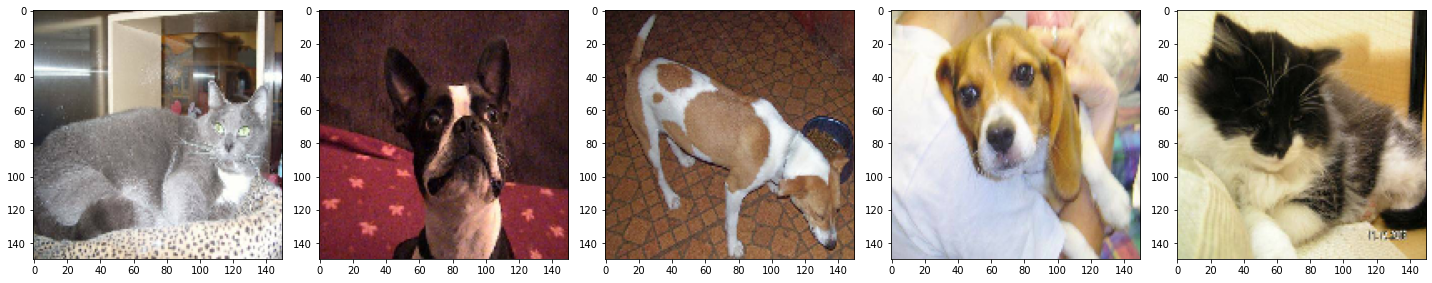

In [16]:
plotImages(sample_training_images[:5])  # Plot images 0-4

# Model Creation

## Define the model
CNN consists of two parts: the first one will extract characteristics from pictures and the last one will classify the pictures (the same as MLP).


<p align="center">
  <img width="460" height="250" img src="https://learnopencv.com/wp-content/uploads/2017/11/cnn-schema1.jpg">
</p>

The images (input) that will go into our convnet are 150x150 (2D) color images. 
The model consists of three convolution blocks with a `relu` and `maxpooling` layer in each of them. Convolutions operate on 3x3 windows and our maxpooling layers operate on 2x2 windows. The first convolution extracts 32 filters, the following one extracts 64 filters, and the last one extracts 128 filters.

MaxPooling downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by `pool_size`, (2,2) in our case) for each channel of the input. The window is shifted by `strides` (the default is the same than `pool_size`, 2) along each dimension.

Then, we have the flatten layer. The final MaxPolling layer has an output of 17x17x128. This has to be converted to a single array and the flatten layer will convert the 3D array into a 1D array of size 17x17x128 = 36992. 

Finally, we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax` with 2 neurons. 

NOTE 1: This is a configuration that is widely used and known to work well for image classification. Also, since we have relatively few training examples (1,000), using just three convolutional modules keeps the model small, which 'lowers' the risk of overfitting (which we'll explore follow).

NOTE 2: The resulting output for the MaxPolling layer with padding and stride values by default, that is, "valid" padding option, has a spatial shape (number of rows or columns) of: output_shape = math.floor((input_shape - pool_size) / strides) + 1 (when input_shape >= pool_size). For example, for `max_pooling2d (MaxPooling2D)` =   (148 - 2)/2 + 1 = 74 --> the half! Then, the output of this layer has dimension (74, 74, 32) because the channels has not been considered. 

In [17]:
modelOrig = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])


### Compile the model

As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `sparse_categorical_crossentropy` as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

NOTE: Adam optimizer automatically adapts the learning rate during training and works well.

In [18]:
modelOrig.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Model Summary

Let's look at all the layers of our network using **summary** method. The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to 'valid' padding, and each pooling layer halves the feature map.

In [19]:
modelOrig.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

### Train the model

It's time we train our network.

Since our batches are coming from a generator (`ImageDataGenerator`), we'll use `fit_generator` instead of `fit`.

In [20]:
EPOCHS = 30
history = modelOrig.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
20/20 [==============================] - 12s 409ms/step - loss: 0.9729 - accuracy: 0.5110 - val_loss: 0.6876 - val_accuracy: 0.5000
Epoch 2/30
20/20 [==============================] - 8s 397ms/step - loss: 0.6845 - accuracy: 0.5470 - val_loss: 0.6781 - val_accuracy: 0.5910
Epoch 3/30
20/20 [==============================] - 8s 398ms/step - loss: 0.6505 - accuracy: 0.6330 - val_loss: 0.7095 - val_accuracy: 0.5280
Epoch 4/30
20/20 [==============================] - 8s 397ms/step - loss: 0.6270 - accuracy: 0.6455 - val_loss: 0.6046 - val_accuracy: 0.6770
Epoch 5/30
20/20 [==============================] - 8s 393ms/step - loss: 0.5498 - accuracy: 0.7285 - val_loss: 0.6235 - val_accuracy: 0.6600
Epoch 6/30
20/20 [==============================] - 8s 390ms/step - loss: 0.5035 - accuracy: 0.7590 - val_loss: 0.5628 - val_accuracy: 0.7230
Epoch 7/30
20/20 [==============================] - 8s 389ms/step - loss: 0.4933 - accuracy: 0.7605 - val_loss: 0.6007 - val_accuracy: 0.6710
Epoch

### Visualizing Intermediate Representations

François Chollet wrote in his book “DEEP LEARNING with Python”:
Intermediate activations are *useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.*

*The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual concepts. Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its activation, the output of the activation function). This gives a view into how an input is decomposed into the different filters learned by the network. Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.*


To see what kind of features our convnet has learned, one fun thing to do is to visualize how an input (the one of the batch selected before) gets transformed as it goes through the convnet.


shape of first layer activation: (97, 148, 148, 32)


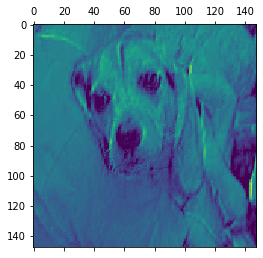

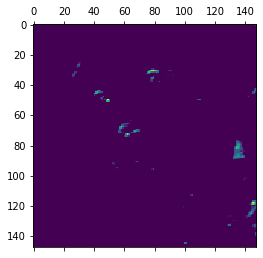

In [21]:
# Outputs of the 6 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in modelOrig.layers[:6]]
activation_model = models.Model(inputs = modelOrig.input, outputs = layer_outputs)

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
activations = activation_model.predict(sample_training_images[3:]) #4th image of sample

# Getting Activations of first layer
first_layer_activation = activations[0]

# shape of first layer activation
print("shape of first layer activation:",first_layer_activation.shape)

# 5th channel of the image after first layer of convolution is applied
plt.matshow(first_layer_activation[0, :, :, 4], cmap ='viridis')
# 14th channel of the image after first layer of convolution is applied
plt.matshow(first_layer_activation[0, :, :, 13], cmap ='viridis')


Initial layers identify low-level features, are more interpretable and retain the majority of the features in the input image. As the level of the layer increases, features become less interpretable, they become more abstract and they identify features specific to the class leaving behind the general features of the image.


Now, let's go on and plot a complete visualization of all the activations in the network. We'll extract and plot every channel in each of our 6 activation maps, and we will stack the results in one big image tensor, with channels stacked side by side.

Let's pick a random cat or dog image from the training set (the batch selected before), and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


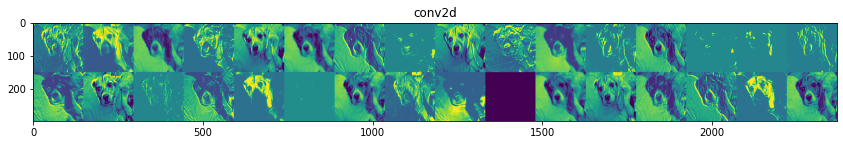

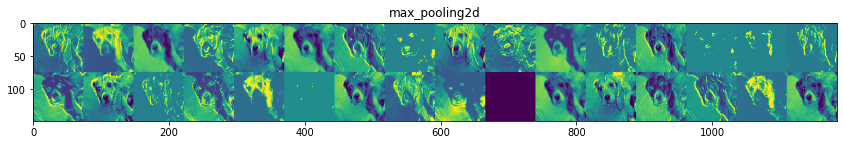

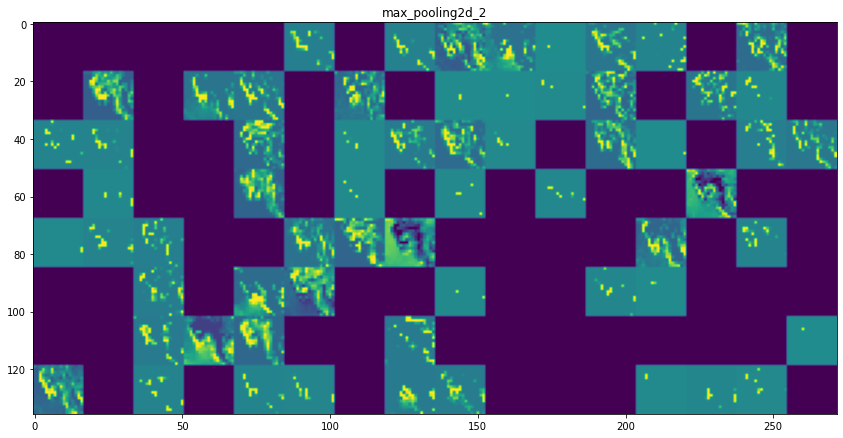

In [22]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in modelOrig.layers[:6]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 0.90 / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.


These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.

Finally, let’s try to interpret what we are seeing:

* The first layer is arguably retaining the full shape of the cat/dog, although there are several filters that are not activated and are left blank. At that stage, the activations retain almost all of the information present in the initial picture.

* As we go deeper in the layers, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as single borders, corners and angles. Higher presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.

* As mentioned above, the model stucture is overly complex to the point where we can see our last layers actually not activating at all, there’s nothing more to learn at that point.

So this is it! We have visualized how a convolutional neural network finds patterns in some basic figures and how it carries the information from one layer to another one.

### Visualizing results of the training

We'll now visualize the results we get after training our network.

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("Max acc on Validation set: {:.2f}".format(max(val_acc)))

loss = history.history['loss']
val_loss = history.history['val_loss']

print("Min loss on Validation set: {:.2f}".format(min(val_loss)))

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

Max acc on Validation set: 0.75
Min loss on Validation set: 0.56


As we can see from the plots, training accuracy and validation accuracy are off by large margin and our model has achieved only around **70%** accuracy on the validation set (depending on the number of epochs you trained for).

This is a clear indication of **overfitting**. Once the training and validation curves start to diverge, our model has started to memorize the training data and is unable to perform well on the validation data. 

Training accuracy (in blue) gets close to 100% while our validation accuracy (in orange) stalls as 70%. Our validation loss reaches its minimum in less than 10 epochs.

Since we have a relatively small number of training examples (2000), overfitting should be our main concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three images of people who are sailors, and among them the only person wearing a cap is a lumberjack, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a bad lumberjack/sailor classifier.

*Overfitting is the central problem in machine learning.*

# Part 2: Alleviating overfitting

Overfitting often occurs when we have a small number of training examples, as we said before. One way to fix this problem is to artificially augment our dataset so that it has sufficient number and variety of training examples. But first we see a simpler way to reduce overfitting, the dropout. 

## 2.1 Using Dropout

*Dropout* is a popular technique in deep learning for fighting overfitting, where we ask the system to randomly ignore features in the neural network.

The previous model `modelOrig` consists of three convolution blocks combined with a max poolling layer. Before the final Dense layers, we apply Dropout with probability of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting because the number of parameters is reduced.



In [24]:
modelDrop = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(2, activation='softmax')
])


In [25]:
modelDrop.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
modelDrop.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)            

### Train the model

In [27]:
EPOCHS = 30
history = modelDrop.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
20/20 [==============================] - 9s 415ms/step - loss: 0.8273 - accuracy: 0.5045 - val_loss: 0.6899 - val_accuracy: 0.5360
Epoch 2/30
20/20 [==============================] - 8s 396ms/step - loss: 0.6789 - accuracy: 0.5810 - val_loss: 0.6629 - val_accuracy: 0.6400
Epoch 3/30
20/20 [==============================] - 8s 405ms/step - loss: 0.6429 - accuracy: 0.6460 - val_loss: 0.6579 - val_accuracy: 0.6020
Epoch 4/30
20/20 [==============================] - 8s 397ms/step - loss: 0.6039 - accuracy: 0.6735 - val_loss: 0.5899 - val_accuracy: 0.6910
Epoch 5/30
20/20 [==============================] - 8s 399ms/step - loss: 0.5533 - accuracy: 0.7270 - val_loss: 0.6446 - val_accuracy: 0.6360
Epoch 6/30
20/20 [==============================] - 8s 410ms/step - loss: 0.5276 - accuracy: 0.7545 - val_loss: 0.6256 - val_accuracy: 0.6820
Epoch 7/30
20/20 [==============================] - 8s 400ms/step - loss: 0.4787 - accuracy: 0.7690 - val_loss: 0.6240 - val_accuracy: 0.6670
Epoch 

We'll now visualize the results we get after training our network.

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("Max acc on Validation set: {:.2f}".format(max(val_acc)))

loss = history.history['loss']
val_loss = history.history['val_loss']

print("Min loss on Validation set: {:.2f}".format(min(val_loss)))

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

Max acc on Validation set: 0.73
Min loss on Validation set: 0.59


## 2.2 Data Augmentation
It is a popular technique to alliviate overfitting when training dataset has very few images. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In **tf.keras** we can implement this using the same **ImageDataGenerator** class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

First, let's define a function that can display an image, so we can see the type of augmentation that has been performed. Then, we'll look at specific augmentations that we'll use during training.

In [29]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Flipping the image horizontally

We can begin by randomly applying horizontal flip augmentation to our dataset and seeing how individual images will look after the transformation. This is achieved by passing `horizontal_flip=True` as an argument to the `ImageDataGenerator` class.

In [30]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


To see the transformation in action, let's take one sample image from our training set and repeat it five times. The augmentation will be randomly applied (or not) to each repetition.

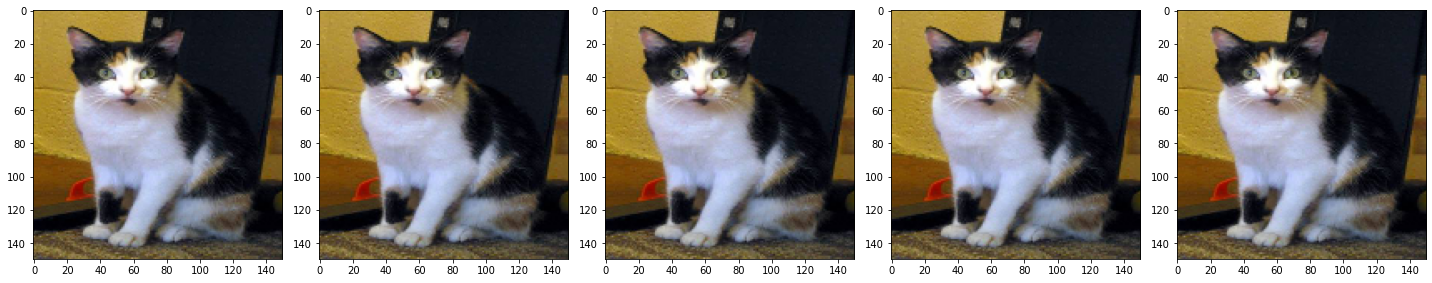

In [31]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Shifting the image 

Shift the image to the left or right (horizontal shifts) or vertically.

In [32]:
image_gen = ImageDataGenerator(rescale=1./255, width_shift_range=0.2)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

augmented_images = [train_data_gen[4][0][0] for i in range(5)]
plotImages(augmented_images)

Found 2000 images belonging to 2 classes.


In [33]:
image_gen = ImageDataGenerator(rescale=1./255, height_shift_range=0.2)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Found 2000 images belonging to 2 classes.


### Rotating the image

The rotation augmentation will randomly rotate the image up to a specified number of degrees. Here, we'll set it to 45.

In [34]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


To see the transformation in action, let's once again take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

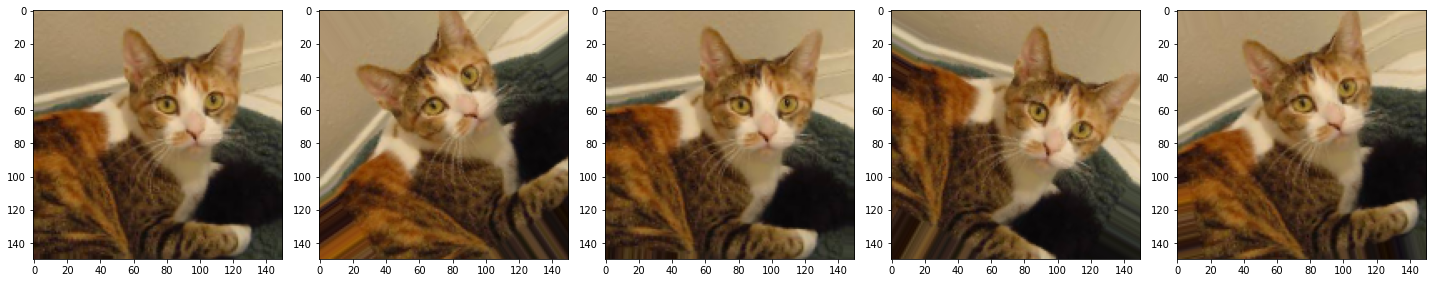

In [35]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Applying Zoom

We can also apply Zoom augmentation to our dataset, zooming images up to 50% randomly.

In [36]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))


Found 2000 images belonging to 2 classes.


One more time, take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

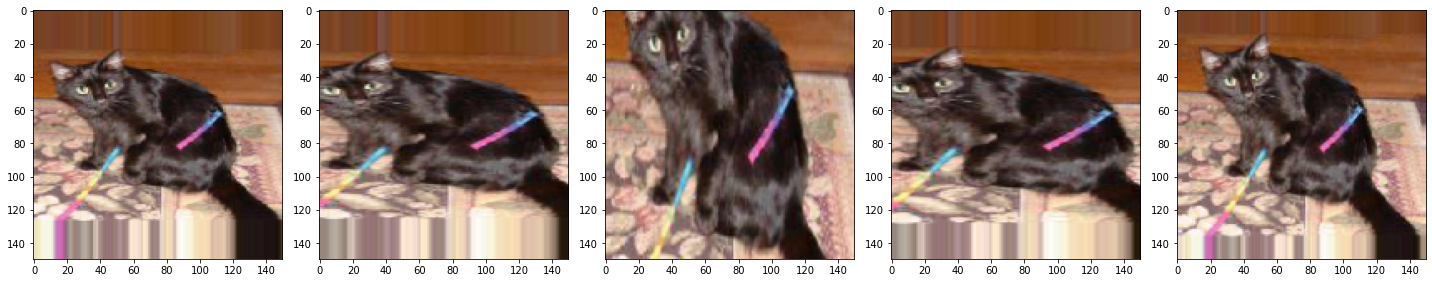

In [37]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Putting it all together

We can apply all these augmentations, and even others, with just one line of code, by passing the augmentations as arguments with proper values.

Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.

In [38]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,        #the image will be distorted along an axis
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Let's visualize how a single image would look like five different times, when we pass these augmentations randomly to our dataset. 

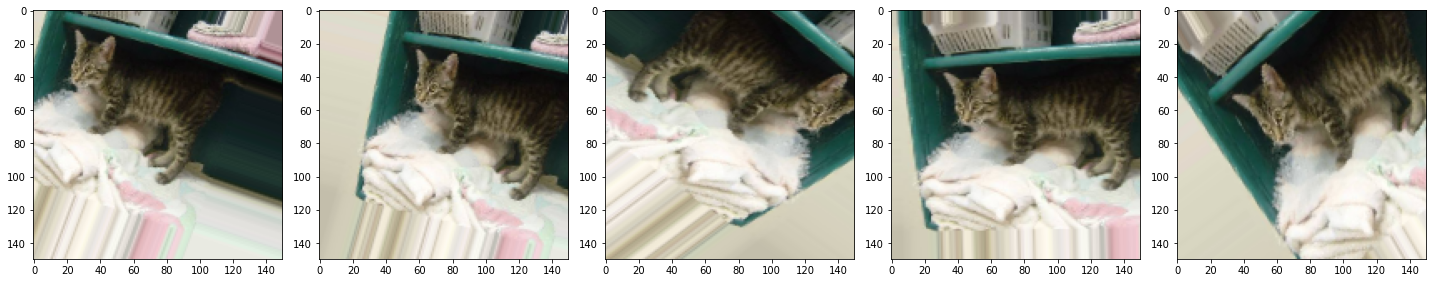

In [39]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Creating Validation Data generator

Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.

In [40]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


# Model Creation

## Define the model

The model is similar to `modelOrig`, we just change the data, now training process will use augmentated data!

In [41]:
modelAug = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

### Compiling the model



In [42]:
modelAug.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Model Summary

Let's look at all the layers of our network using **summary** method.

In [43]:
modelAug.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 36992)            

### Train the model

It's time we train our network.


In [44]:
epochs=30
history = modelAug.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
20/20 [==============================] - 16s 779ms/step - loss: 1.2519 - accuracy: 0.5350 - val_loss: 0.6919 - val_accuracy: 0.4990
Epoch 2/30
20/20 [==============================] - 15s 765ms/step - loss: 0.6939 - accuracy: 0.5100 - val_loss: 0.6881 - val_accuracy: 0.5910
Epoch 3/30
20/20 [==============================] - 15s 761ms/step - loss: 0.6913 - accuracy: 0.5225 - val_loss: 0.6831 - val_accuracy: 0.6090
Epoch 4/30
20/20 [==============================] - 15s 772ms/step - loss: 0.6827 - accuracy: 0.5565 - val_loss: 0.6579 - val_accuracy: 0.6310
Epoch 5/30
20/20 [==============================] - 16s 782ms/step - loss: 0.6703 - accuracy: 0.5890 - val_loss: 0.6616 - val_accuracy: 0.5980
Epoch 6/30
20/20 [==============================] - 15s 773ms/step - loss: 0.6529 - accuracy: 0.6185 - val_loss: 0.6495 - val_accuracy: 0.6380
Epoch 7/30
20/20 [==============================] - 16s 788ms/step - loss: 0.6555 - accuracy: 0.6100 - val_loss: 0.6224 - val_accuracy: 0.6630

### Visualizing results of the training

We'll now visualize the results we get after training our network.

Max acc on Validation set: 0.74
Min loss on Validation set: 0.50


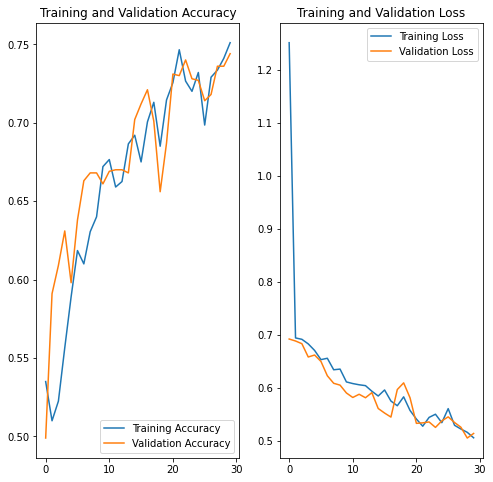

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("Max acc on Validation set: {:.2f}".format(max(val_acc)))

loss = history.history['loss']
val_loss = history.history['val_loss']

print("Min loss on Validation set: {:.2f}".format(min(val_loss)))

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The validation accuracy is mostly better than training accuracy. This means that the model has generalized well. This comes from the fact that the model has been trained on more data ( for example – flipped images ), so it is finding the normal validation (test) data easier to classify. 

## 2.3 Combining Dropout + Augmentation
Let's see a final model using both techiniques.


## Define the model



In [46]:
modelFinal = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
     
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(2, activation='softmax')
])

### Compiling the model



In [47]:
modelFinal.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Model Summary

Let's look at all the layers of our network using **summary** method.

In [48]:
modelFinal.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 36992)            

### Train the model

In [49]:
epochs=30
history = modelFinal.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
20/20 [==============================] - 16s 779ms/step - loss: 0.8837 - accuracy: 0.5095 - val_loss: 0.6787 - val_accuracy: 0.5550
Epoch 2/30
20/20 [==============================] - 15s 759ms/step - loss: 0.6856 - accuracy: 0.5670 - val_loss: 0.6674 - val_accuracy: 0.5300
Epoch 3/30
20/20 [==============================] - 15s 754ms/step - loss: 0.6830 - accuracy: 0.5555 - val_loss: 0.6613 - val_accuracy: 0.5080
Epoch 4/30
20/20 [==============================] - 15s 761ms/step - loss: 0.6646 - accuracy: 0.5745 - val_loss: 0.6918 - val_accuracy: 0.5330
Epoch 5/30
20/20 [==============================] - 15s 757ms/step - loss: 0.6592 - accuracy: 0.6155 - val_loss: 0.7016 - val_accuracy: 0.5390
Epoch 6/30
20/20 [==============================] - 15s 759ms/step - loss: 0.6412 - accuracy: 0.6320 - val_loss: 0.6277 - val_accuracy: 0.6210
Epoch 7/30
20/20 [==============================] - 15s 760ms/step - loss: 0.6265 - accuracy: 0.6475 - val_loss: 0.6199 - val_accuracy: 0.6770

### Visualizing results of the training

Max acc on Validation set: 0.77
Min loss on Validation set: 0.49


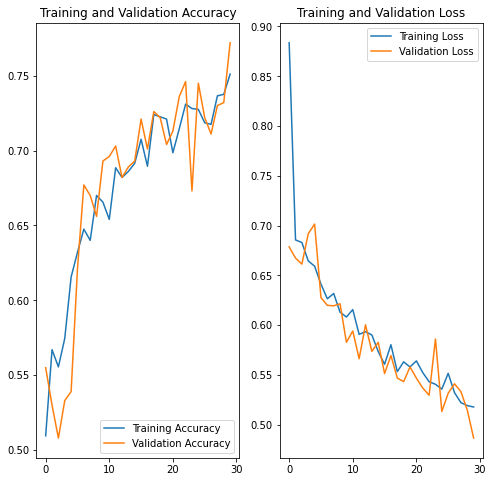

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("Max acc on Validation set: {:.2f}".format(max(val_acc)))

loss = history.history['loss']
val_loss = history.history['val_loss']

print("Min loss on Validation set: {:.2f}".format(min(val_loss)))

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()